In [4]:
import numpy as np
import pymc as pm
import math

# Random Normal data

In [11]:
data = np.random.normal(0, 1, 1000)

In [84]:
def loglike_fn(mu, sigma, data):
    n = len(data)
    # Calculate log-likelihood using PyMC/Aesara functions
    log_likelihood = -n/2 * pm.math.log(2 * np.pi) - n * pm.math.log(sigma) - (1/(2 * sigma**2)) * pm.math.sum((data - mu)**2)
    print(type(log_likelihood))
    return log_likelihood


In [85]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=-1, upper=1)
    sigma = pm.Uniform('sigma', lower=1, upper=3)

    # print('sigma ', pm.draw(sigma))

    likelihood = pm.Potential('likelihood', loglike_fn(mu, sigma, data))

    trace = pm.sample(1000, step = pm.NUTS())


<class 'pytensor.tensor.variable.TensorVariable'>


KeyboardInterrupt: 

In [15]:
print(pm.summary(trace))

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.003  0.032  -0.059    0.061      0.001    0.001    2054.0    2012.0   
sigma  1.010  0.009   1.000    1.027      0.000    0.000    1932.0    1403.0   

       r_hat  
mu       1.0  
sigma    1.0  


In [28]:
import matplotlib.pyplot as plt

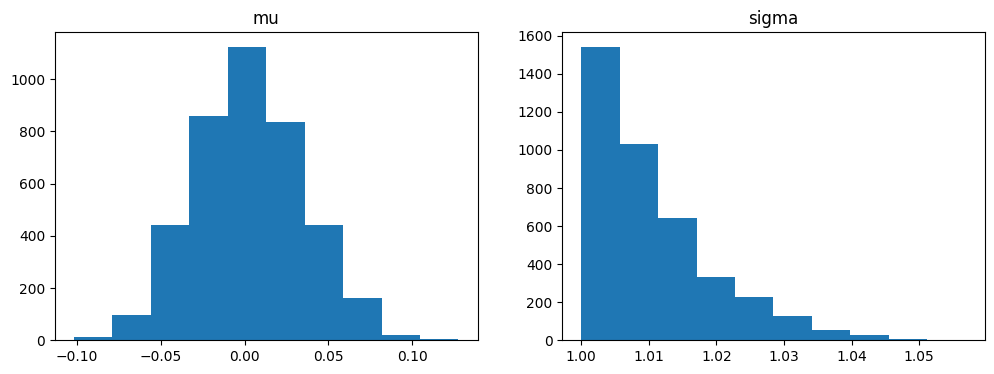

In [36]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(trace.posterior['mu'].values.flatten()); plt.title('mu')
plt.subplot(1,2,2)
plt.hist(trace.posterior['sigma'].values.flatten()); plt.title('sigma');

In [34]:
trace.posterior['mu'].values.flatten().shape


(4000,)

# DDM

In [1]:
from ddm_utils import simulate_ddm, parse_sim_results
from joblib import Parallel, delayed
import pickle
import aesara.tensor as at
import pytensor.tensor as pt

/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/numpy/distutils/system_info.py:2159: UserWarning: 
    Optimized (vendor) Blas libraries are not found.
    Falls back to netlib Blas library which has worse performance.
    A better performance should be easily gained by switching
    Blas library.
  if self._calc_info(blas):
/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/numpy/distutils/system_info.py:2159: UserWarning: 
    Blas (http://www.netlib.org/blas/) libraries not found.
    Directories to search for the libraries can be specified in the
    numpy/distutils/site.cfg file (section [blas]) or by setting
    the BLAS environment variable.
  if self._calc_info(blas):
/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/numpy/distutils/system_info.py:2159: UserWarning: 
    Blas (http://www.netlib.org/blas/) sources not found.
    Directories to search for the sources can be specified in the
    numpy/distutils/site.cfg file (section [blas_src]) or by s

In [22]:
N_sim = 100; v = 0.2; a = 2
sim_results = Parallel(n_jobs=-1)(delayed(simulate_ddm)(v, a) for _ in range(N_sim))


choices, RTs = parse_sim_results(sim_results)
    
with open('sample_rt.pkl', 'wb') as f:
    pickle.dump(RTs, f)
with open('sample_choice.pkl', 'wb') as f:
    pickle.dump(choices, f)

data_dict = {'choices': choices, 'RTs': RTs}

In [41]:
def rtd_density_a_NUTS(t, v, a, w, K_max=10):
    if t > 0.25:
        non_sum_term = (math.pi/a**2)*pm.math.exp(-v*a*w - (v**2 * t/2))
        k_vals = np.linspace(1, K_max, K_max)
        sum_sine_term = pm.math.sin(k_vals*np.pi*w)
        sum_exp_term = pm.math.exp(-(k_vals**2 * np.pi**2 * t)/(2*a**2))
        sum_result = pm.math.sum(k_vals * sum_sine_term * sum_exp_term)
    else:
        non_sum_term = (1/a**2)*(a**3/pm.math.sqrt(2*math.pi*t**3))*pm.math.exp(-v*a*w - (v**2 * t)/2)
        K_max = int(K_max/2)
        k_vals = np.linspace(-K_max, K_max, 2*K_max + 1)
        sum_w_term = w + 2*k_vals
        sum_exp_term = pm.math.exp(-(a**2 * (w + 2*k_vals)**2)/(2*t))
        sum_result = pm.math.sum(sum_w_term*sum_exp_term)

    # print('This is possible ? ',type(non_sum_term), type(sum_result))
    density =  non_sum_term * sum_result
    # if density <= 0:
    #     density = 1e-10
    return density


def loglike_fn_NUTS(v,a,w,data):
    choices = np.array(data['choices'])
    RTs = np.array(data['RTs'])

    choices_pos = np.where(choices == 1)[0]
    choices_neg = np.where(choices == -1)[0]

    RTs_pos = RTs[choices_pos]
    RTs_neg = RTs[choices_neg]

    prob_pos = [rtd_density_a_NUTS(t, -v, a, 1-w) for t in RTs_pos]
    prob_neg = [rtd_density_a_NUTS(t, v, a, w) for t in RTs_neg]
    # prob_pos = np.array(prob_pos)
    # prob_neg = np.array(prob_neg)

    # prob_pos[prob_pos <= 0] = 1e-10
    # prob_neg[prob_neg <= 0] = 1e-10

    log_pos = pm.math.log(prob_pos)
    log_neg = pm.math.log(prob_neg)
    
    
    sum_loglike = (pm.math.sum(log_pos) + pm.math.sum(log_neg))
    return sum_loglike


with pm.Model() as model:
    v_ = pm.Uniform('v', lower=-2, upper=2)
    a_ = pm.Uniform('a', lower=1, upper=3)
    w_ = pm.Uniform('w', lower=0.3, upper=0.7)

    likelihood = pm.Potential('likelihood', loglike_fn_NUTS(v_,a_,w_, data_dict))

    trace = pm.sample(draws=1000, step = pm.NUTS(), chains=1, tune=100, discard_tuned_samples=False)

Sequential sampling (1 chains in 1 job)
NUTS: [v, a, w]


Output()

Sampling 1 chain for 100 tune and 1_000 draw iterations (100 + 1_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Text(0.5, 1.0, 'w')

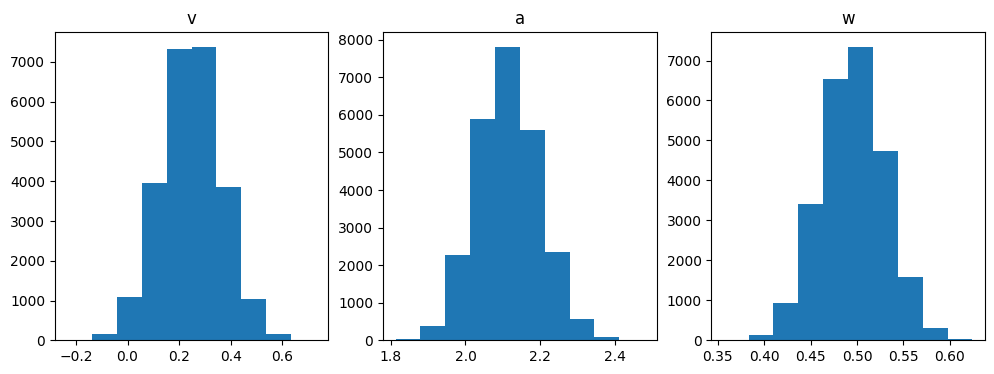

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.hist(trace.posterior['v'].values.flatten()); plt.title('v')
plt.subplot(1,3,2)
plt.hist(trace.posterior['a'].values.flatten()); plt.title('a');
plt.subplot(1,3,3)
plt.hist(trace.posterior['w'].values.flatten()); plt.title('w')

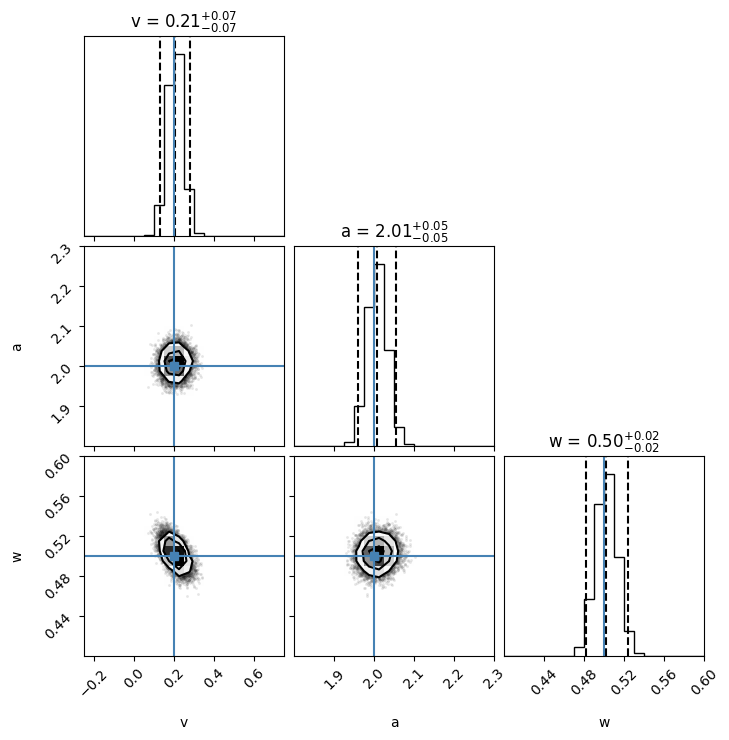

In [20]:
import corner
v_samples = trace.posterior['v'].values.flatten()
a_samples = trace.posterior['a'].values.flatten()
w_samples = trace.posterior['w'].values.flatten()

combined_samples = np.transpose(np.vstack((v_samples, a_samples, w_samples)))


limits = [(-0.25, 0.75), (1.8, 2.3), (0.4, 0.6) ]
true_mu = 0
true_sigma = 1
truths = [0.2, 2, 0.5]

figure = corner.corner(combined_samples, labels=["v", "a","w"], show_titles=True, quantiles=[0.025, 0.5, 0.975],range=limits, truths=truths)

pictures_path = "/home/rka/Pictures"  # Replace with your desired path
filename = "nuts_corner_plot.png"  # You can change the filename as needed

# Create the directory if it doesn't exist

# Save the figure
# import os
# plt.savefig(os.path.join(pictures_path, filename))
# plt.close(figure)  # Close the figure to free 
plt.show()


# testing autocorr of samples

In [181]:
import matplotlib.pyplot as plt


In [193]:
def autocorrelation(x, lag):
    n = len(x)
    mean = np.mean(x)
    c0 = np.sum((x - mean) ** 2) / n
    return np.sum((x[:n-lag] - mean) * (x[lag:] - mean)) / (n * c0)

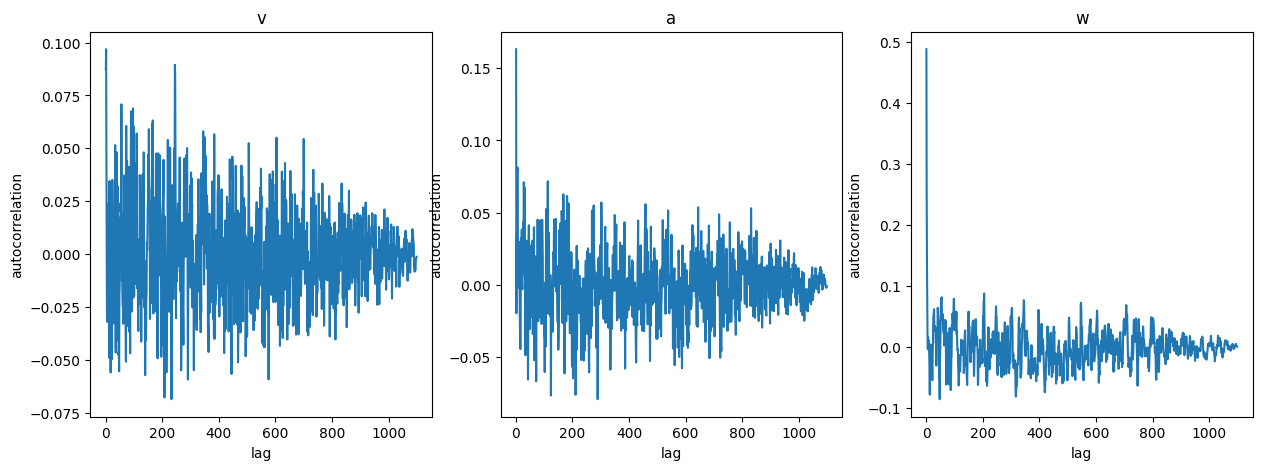

In [195]:
params_list = ['v', 'a', 'w']
plt.figure(figsize=(15, 5))

for idx,param in enumerate(params_list):
    warmup = trace.warmup_posterior[param]
    actual = trace.posterior[param]

    combined_samples = np.concatenate([warmup, actual], axis=1)
    combined_samples = combined_samples.tolist()

    x = combined_samples[0]
    x = np.array(x)

    lags = np.arange(1, 1100)
    autocorr_values = [autocorrelation(x, lag) for lag in lags]

    plt.subplot(1, 3, idx+1)
    plt.plot(lags, autocorr_values);
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    plt.title(param)







Text(0.5, 1.0, 'a')

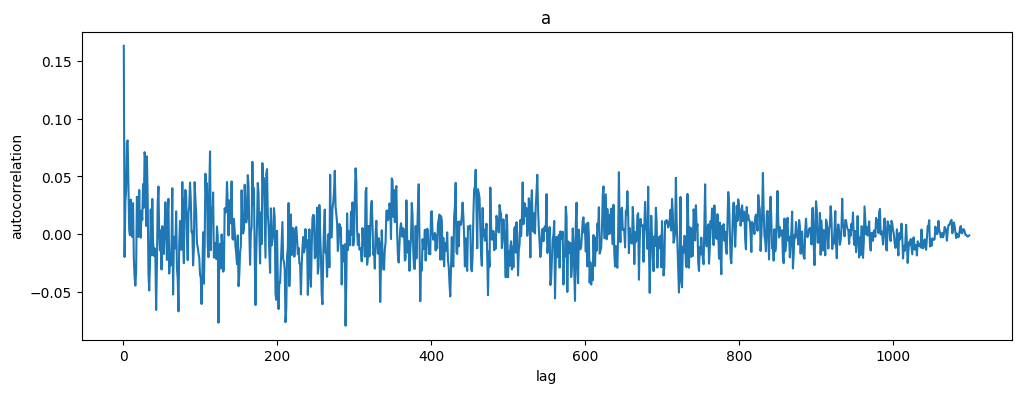

In [197]:
param = 'a'
warmup = trace.warmup_posterior[param]
actual = trace.posterior[param]

combined_samples = np.concatenate([warmup, actual], axis=1)
combined_samples = combined_samples.tolist()

x = combined_samples[0]
x = np.array(x)

lags = np.arange(1, 1100)
autocorr_values = [autocorrelation(x, lag) for lag in lags]

plt.figure(figsize=(12, 4))
plt.plot(lags, autocorr_values);
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.title(param)

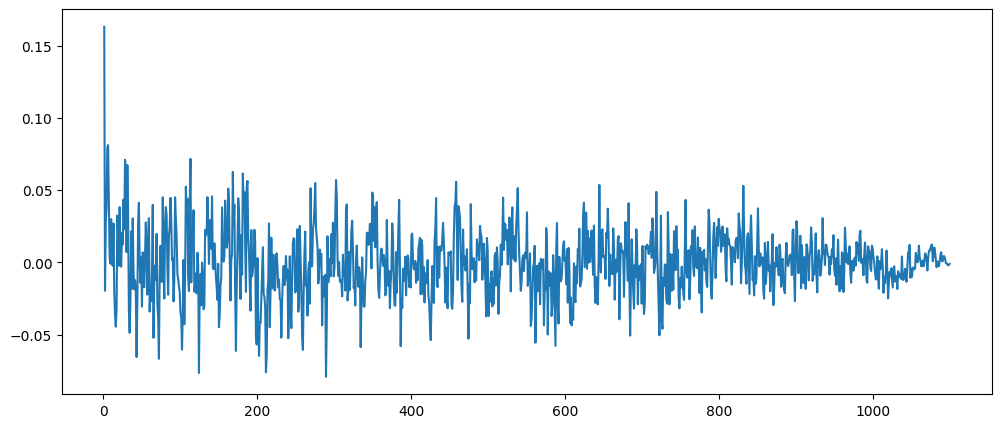